In [1]:
import drjit as dr
import mitsuba as mi
mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from matplotlib import pyplot as plt

## Ink Parameters ##

In [3]:
#  s / (a + s)
ink_albedo = np.array([
    [0.05, 0.7, 0.98],  # Cyan
    [0.98, 0.1, 0.9],  # Magenta
    [0.997, 0.995, 0.15],  # Yellow
    [0.35, 0.35, 0.35],  # KEY: Black
    [0.9991, 0.9997, 0.999],   # White
    [1.0, 1.0, 1.0] #Transparent
    ])
# ink_albedo = torch.tensor(ink_albedo, dtype=torch.float32)

# a + s
ink_sigma_t = np.array([
        [9.0, 4.5, 7.5],  # Cyan
        [2.5, 3.0, 10.0],  # Magenta
        [2.25, 3.75, 19.0],  # Yellow
        [5.0, 5.5, 6.5],  # KEY: Black
        [6.0, 9.0, 24.0],   # White
        [1e-4, 1e-4, 1e-4]] #Transparent
        ) /20
# ink_sigma_t = torch.tensor(ink_sigma_t, dtype=torch.float32)

has_transparent = False
weight = np.random.rand(6)
if not has_transparent:
    weight[5] = 0.0
weight = weight / weight.sum()
weight = torch.tensor(weight, dtype=torch.float32)

In [4]:
ink_scattering = ink_albedo * ink_sigma_t
ink_absorption = ink_sigma_t - ink_scattering

ink_absorption = torch.tensor(ink_absorption, dtype=torch.float32)
ink_scattering = torch.tensor(ink_scattering, dtype=torch.float32)

## Thickness Experiement ##

In [5]:
from mitsuba import ScalarTransform4f as T

sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0, 0, 100], up=[0, 1, 0])
sensor_thickness_experiment = mi.load_dict({
    'type': 'perspective',
    'fov': 45,
    'to_world': sensor_to_world,
    'film': {
        'type': 'hdrfilm',
        'width': 64, 'height': 64,
        'filter': {'type': 'tent'}
    }
})

In [6]:
from mitsuba.scalar_rgb import Transform4f as T

def load_scene_diff_cube(scale_3, sigma_scale = 20):

    translate_3 = - scale_3 + 20
    scene = mi.load_dict({
        'type': 'scene',
        'integrator': {'type': 'volpathmis'},
        'red_cude': {
            'type': 'cube', #red cude
            # 'to_world': T.scale([10,10,20]).translate([0,0,- translte_3]),
            'to_world': T.translate([0,0,translate_3]).scale([10,10,scale_3]),
            'bsdf': {'type': 'null'},
            'interior': {
                'type': 'homogeneous',
                'albedo': {
                    'type': 'rgb',
                    'value': [1.0, 0.0, 0.0]
                },
                'sigma_t': {
                    'type': 'rgb',
                    'value': [1.0, 0.0, 0.0]
                },
                'scale': sigma_scale
            }
        },
        'emitter': {'type': 'constant'}
    })

    return scene



In [7]:
def render_diff_cube(s,filepath):
    w = torch.tensor([0.0000, 0.5107, 0.4893, 0.0000, 0.0000, 0.0000])
    # w = torch.tensor([0.0974, 0.0000, 0.9026, 0.0000, 0.0000, 0.0000])

    sigma_t = (w @ (ink_absorption+ ink_scattering))
    albedo = (w @ ink_scattering / sigma_t)
    sigma_t = sigma_t.detach().numpy()
    albedo = albedo.detach().numpy()

    cube_thickness = [0.1,0.5,2,5,10,20,40,70,100]
    imgs = []
    for scale_3 in cube_thickness:
        scene = load_scene_diff_cube(scale_3)
        key_albedo = 'red_cude.interior_medium.albedo.value.value'
        key_sigma_t = 'red_cude.interior_medium.sigma_t.value.value'
        params = mi.traverse(scene)
        params[key_albedo] = albedo
        params[key_sigma_t] = sigma_t
        params.update()
        img = mi.render(scene, params, sensor=s, spp=1024)
        imgs.append(img)

        name = filepath+'red_10_10_'+str(scale_3)
        mi.Bitmap(img).write(name+'.exr')
    scene_thick_sigma = load_scene_diff_cube(0.1, sigma_scale = 20 * 0.5/0.1)
    params = mi.traverse(scene_thick_sigma)
    params[key_albedo] = albedo
    params[key_sigma_t] = sigma_t
    params.update()
    img_thick_sigma = mi.render(scene_thick_sigma, params, sensor=s, spp=1024)
    name = filepath+'red_0.1_scale_20*5'
    mi.Bitmap(img_thick_sigma).write(name+'.exr')

    return imgs

In [8]:
imgs = render_diff_cube(sensor_thickness_experiment,filepath = 'thickness_experiment/')

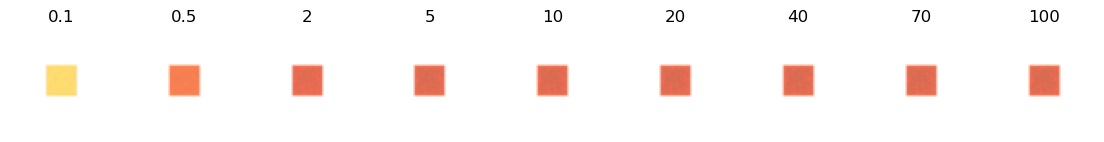

In [65]:
fig, axs = plt.subplots(1, len(imgs), figsize=(14, 4))
for i in range(len(imgs)):
    axs[i].imshow(mi.util.convert_to_bitmap(imgs[i]))
    axs[i].title.set_text(str([0.1,0.5,2,5,10,20,40,70,100][i]))
    axs[i].axis('off')
plt.savefig("thickness_experiment/red.png")
plt.show()

## Ink Mixture Optimization ##

In [9]:

R = np.array([1.0,0.0,0.0])
G = np.array([0.0,1.0,0.0])
W = np.array([1.0,1.0,1.0])

R_opacity = 0.4 if has_transparent else 1.0
G_opacity = 0.25 if has_transparent else 1.0

r_front_w_back = R * R_opacity + W * (1.0 - R_opacity)
g_front_r_back = G * G_opacity + r_front_w_back * (1.0 - G_opacity)

# final_color = g_front_r_back

GT_color = G
print(GT_color)

ink_mixture_filepath = 'ink_mixture_optimization/'



[0. 1. 0.]


In [10]:
def get_GT_scene(target_RGB, thickness = 10):
    translate_3 = - thickness + 20
    scene = mi.load_dict({
            'type': 'scene',
            'integrator': {'type': 'volpathmis'},
            'red_cude': {
                'type': 'cube', #red cude
                # 'to_world': T.scale([10,10,20]).translate([0,0,- translte_3]),
                'to_world': T.translate([0,0,translate_3]).scale([40,40,thickness]),
                'bsdf': {
                'type': 'diffuse',
                'reflectance': {
                    'type': 'rgb',
                    'value': list(target_RGB)
                }},
            },
            'emitter': {'type': 'constant'}
        })
    return scene

def get_optimization_scene(thickness = 10, integrator_type = 'prbvolpath'):
    translate_3 = - thickness + 20
    scene = mi.load_dict({
        'type': 'scene',
        'integrator': {'type': integrator_type},
        'red_cude': {
            'type': 'cube', #red cude
            # 'to_world': T.scale([10,10,20]).translate([0,0,- translte_3]),
            'to_world': T.translate([0,0,translate_3]).scale([40,40,thickness]),
            'bsdf': {'type': 'null'},
            'interior': {
                'type': 'homogeneous',
                'albedo': {
                    'type': 'rgb',
                    'value': [1.0, 0.0, 0.0]
                },
                'sigma_t': {
                    'type': 'rgb',
                    'value': [1.0, 0.0, 0.0]
                },
                'scale': 20
            }
        },
        'emitter': {'type': 'constant'}
    })

    return scene

In [11]:
GT_scene = get_GT_scene(GT_color)
GT_image = mi.render(GT_scene, sensor= sensor_thickness_experiment, spp=1024)
mi.util.convert_to_bitmap(GT_image)
name_tail = 'red' if np.array_equal(GT_color, R) else 'green'
mi.Bitmap(GT_image).write(ink_mixture_filepath+'GT_'+name_tail+ '.exr')


In [13]:
from kornia.color import rgb_to_lab
GT_mean_RGB = GT_image.torch().mean(dim=(0, 1)).reshape(1, 3,1,1)
# lab_ref = rgb_to_lab(GT_image.torch().reshape(1, 3, 64, 64)).reshape(64,64,3)
lab_ref = rgb_to_lab(GT_mean_RGB)

In [14]:
opt_scene = get_optimization_scene()
opt_init_image = mi.render(opt_scene, sensor= sensor_thickness_experiment, spp=1024)
mi.util.convert_to_bitmap(opt_init_image)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [15]:
key_albedo = 'red_cude.interior_medium.albedo.value.value'
key_sigma_t = 'red_cude.interior_medium.sigma_t.value.value'
params = mi.traverse(opt_scene)

@dr.wrap_ad(source='torch', target='drjit')
def render_texture(albedo, sigma_t, spp = 256):
    params[key_albedo] = dr.unravel(mi.Color3f, albedo)
    params[key_sigma_t] = dr.unravel(mi.Color3f, sigma_t)
    params.update()
    render = mi.render(opt_scene, params, sensor= sensor_thickness_experiment, spp=spp)
    return render
    # return mi.render(scene, params, spp=spp, seed=seed, seed_grad=seed+1)

In [16]:

use_delta_e76 = True
lr = 0.01

weight = torch.tensor(weight, requires_grad=True)
optimizer = torch.optim.Adam([weight], lr=lr)


# Optimization hyper-parameters
iteration_count = 100
spp = 512

/var/folders/rf/6xptcpl97sg4y_z285cqg0x00000gn/T/ipykernel_10853/2963020254.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = torch.tensor(weight, requires_grad=True)


In [17]:



def loss_delta_76_mse_func(w):
    w = F.relu(w)
    w = w / torch.sum(w)
    sigma_t = w @ (ink_absorption + ink_scattering)
    albedo = w @ ink_scattering / sigma_t
    current_render = render_texture(albedo, sigma_t)
    mean_opt_RGB = current_render.mean(dim=(0, 1)).reshape(1, 3,1,1)
    lab_image = rgb_to_lab(mean_opt_RGB)
    dE76 = torch.sqrt(torch.sum((lab_image - lab_ref)**2))
    # delta_e76 = torch.sqrt(torch.sum((lab_image - lab_ref)**2, dim=(0, 1))/(64*64))
    return 0.1 * dE76 + 0.9 * F.mse_loss(current_render, GT_image.torch())

def loss_delta_76_func(w,i):
    w = F.relu(w)
    w = w / torch.sum(w)
    sigma_t = w @ (ink_absorption + ink_scattering)
    albedo = w @ ink_scattering / sigma_t
    current_render = render_texture(albedo, sigma_t)
    mean_opt_RGB = current_render.mean(dim=(0, 1)).reshape(1, 3,1,1)
    lab_image = rgb_to_lab(mean_opt_RGB)
    dE76 = torch.sqrt(torch.sum((lab_image - lab_ref)**2))
    # delta_e76 = torch.sqrt(torch.sum((lab_image - lab_ref)**2, dim=(0, 1))/(64*64))
    return dE76


def loss_func(w):
    w = F.relu(w)
    w = w / torch.sum(w)
    sigma_t = w @ (ink_absorption + ink_scattering)
    albedo = w @ ink_scattering / sigma_t
    current_render = render_texture(albedo, sigma_t)
    # MSE between the reference and the current render
    return F.mse_loss(current_render, GT_image.torch())


In [18]:

train_losses = []
torch.autograd.set_detect_anomaly(True)
for i in range(iteration_count):
    optimizer.zero_grad()
    loss = loss_func(weight) if not use_delta_e76 else loss_delta_76_func(weight,i)

    if i == 0:
        print(f'Initial loss: {loss}')
    loss.backward()
    optimizer.step()
    train_losses.append(loss)
    print(f'Training iteration {i+1}/{iteration_count}, loss: {train_losses[-1]}', end='\r')


Initial loss: 162.2252197265625


In [19]:
print(weight)
w = F.relu(weight)
w = w / torch.sum(w)
print(w)

tensor([ 0.0459, -0.1231,  0.4254, -0.1158, -0.0499,  0.0000],
       requires_grad=True)
tensor([0.0974, 0.0000, 0.9026, 0.0000, 0.0000, 0.0000],
       grad_fn=<DivBackward0>)


In [20]:
scene_mis = get_optimization_scene(integrator_type = 'volpathmis')
params_mis = mi.traverse(scene_mis)

sigma_t = (w @ (ink_absorption+ ink_scattering))
albedo = (w @ ink_scattering / sigma_t)
sigma_t = sigma_t.detach().numpy()
albedo = albedo.detach().numpy()
params_mis[key_albedo] = albedo
params_mis[key_sigma_t] = sigma_t
params_mis.update()
img = mi.render(scene_mis, params_mis, sensor=sensor_thickness_experiment, spp=1024)
mi.util.convert_to_bitmap(img)


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 12 KiB of image data ]
]

In [21]:
print(img.numpy().mean(axis=(0, 1)))
# print(GT_image.numpy().mean(axis=(0, 1)))
print(img.torch().mean(dim=(0, 1)))


a = rgb_to_lab(img.torch().mean(dim=(0, 1)).reshape(1, 3,1,1))
b = rgb_to_lab(GT_image.torch().mean(dim=(0, 1)).reshape(1, 3,1,1))
dE76 = torch.sqrt(torch.sum((a - lab_ref)**2))
print("after optimization dE76",dE76)


opt_tensor = opt_init_image.torch()
mean_opt_RGB = opt_tensor.mean(dim=(0, 1)).reshape(1, 3,1,1)
lab_image = rgb_to_lab(mean_opt_RGB)
dE76 = torch.sqrt(torch.sum((lab_image - lab_ref)**2))
print("before optimization dE76",dE76)

[0.21945044 0.57472724 0.03058846]
tensor([0.2195, 0.5747, 0.0306])
after optimization dE76 tensor(58.0163)
before optimization dE76 tensor(109.7580)


### Ink Optimization Results ###

Red:
- dE76: 137.75 --> 34.1736
- weight: [0.0000, 0.5136, 0.4864, 0.0000, 0.0000, 0.0000]

Green:
-dE76: 109.75 --> 57.58
- weight: [0.0944, 0.0000, 0.9056, 0.0000, 0.0000, 0.0000]

## Ink Gradient ##

In [51]:
def gaussian(x):
    variance = 1.0
    mean = 0.0
    return 1.0 / (np.sqrt(2.0 * np.pi) * variance) * np.exp(-np.power((x - mean) / variance, 2.0) / 2)

sample_point = np.arange(0, 3.5, 0.25)
mix_ratio = gaussian(sample_point)
print(sample_point)
print(mix_ratio)

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25]
[0.39894228 0.38666812 0.35206533 0.30113743 0.24197072 0.18264909
 0.1295176  0.08627732 0.05399097 0.03173965 0.0175283  0.00909356
 0.00443185 0.00202905]


In [56]:
# mix_ratio = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9,1.0]
mix_ratio = [0.0, 0.5, 0.7, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]

w_r = torch.tensor([0.0000, 0.5136, 0.4864, 0.0000, 0.0000, 0.0000])
w_g = torch.tensor([0.0944, 0.0000, 0.9056, 0.0000, 0.0000, 0.0000])

r_absorption = w_r @ ink_absorption
r_scattering = w_r @ ink_scattering
g_absorption = w_g @ ink_absorption
g_scattering = w_g @ ink_scattering

trans_absorption = ink_absorption[5]
trans_scattering = ink_scattering[5]


scene_gradient = get_optimization_scene(integrator_type = 'volpathmis')
params_gradient = mi.traverse(scene_gradient)

imgs = []
filepath = 'ink_gradient/'

is_r_g_mix, is_red_transparent_mix, is_green_transparent_mix = False, True, False


for i, mix in enumerate(mix_ratio):
    if is_r_g_mix:
        final_absorption = r_absorption * (1 - mix) + g_absorption * mix
        final_scattering = r_scattering * (1 - mix) + g_scattering * mix
        name_tail = 'red_2_green/red_2_green_'

    if is_red_transparent_mix:
        final_absorption = r_absorption * (1 - mix) + trans_absorption * mix
        final_scattering = r_scattering * (1 - mix) + trans_scattering * mix
        name_tail = 'red_2_trans/red_2_trans_'

    if is_green_transparent_mix:
        final_absorption = g_absorption * (1 - mix) + trans_absorption * mix
        final_scattering = g_scattering * (1 - mix) + trans_scattering * mix
        name_tail = 'green_2_trans/green_2_trans_'

    final_sigma_t = final_absorption + final_scattering
    final_albedo = final_scattering / final_sigma_t
    sigma_t = final_sigma_t.detach().numpy() 
    albedo = final_albedo.detach().numpy()
    # print(sigma_t, albedo)
    params_gradient[key_albedo] = albedo
    params_gradient[key_sigma_t] = sigma_t
    params_gradient.update()
    img = mi.render(scene_gradient, params_gradient, sensor=sensor_thickness_experiment, spp=1024)
    imgs.append(img)
    
    name = filepath+name_tail+str(mix)
    mi.Bitmap(img).write(name+'.exr')



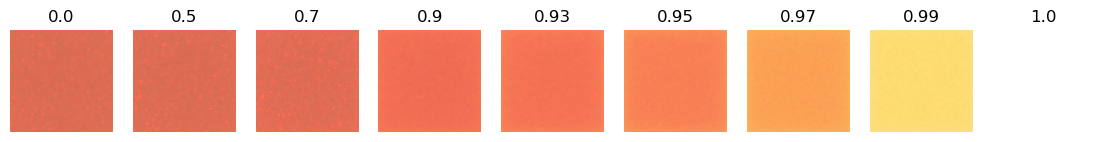

In [57]:
fig, axs = plt.subplots(1, len(imgs), figsize=(14, 4))
for i in range(len(imgs)):
    axs[i].imshow(mi.util.convert_to_bitmap(imgs[i]))
    axs[i].title.set_text(str(mix_ratio[i]))
    axs[i].axis('off')
plt.savefig(filepath+name_tail + "_mix.png")
plt.show()

### Layer Adding ###

In [29]:
def get_2_layer_scene(thickness = 10, integrator_type = 'prbvolpath'):
    translate_3 = - thickness + 20
    scene = mi.load_dict({
        'type': 'scene',
        'integrator': {'type': integrator_type},
        'red_cude': {
            'type': 'cube', #red cude
            # 'to_world': T.scale([10,10,20]).translate([0,0,- translte_3]),
            'to_world': T.translate([0,0,translate_3]).scale([29,29,thickness]),
            # 'bsdf':{'type': 'diffuse',
            # 'reflectance': {
            #     'type': 'rgb',
            #     'value': [1,0,0]
            # }}
            'bsdf': {'type': 'null'},
            'interior': {
                'type': 'homogeneous',
                'albedo': {
                    'type': 'rgb',
                    'value': [1.0, 1.0, 1.0]
                },
                'sigma_t': {
                    'type': 'rgb',
                    'value': [1.0, 0.0, 0.0]
                },
                'scale': 20
            }
        },
        'green_cude': {
            'type': 'cube', #red cude
            # 'to_world': T.scale([10,10,20]).translate([0,0,- translte_3]),
            'to_world': T.translate([0,0,translate_3-thickness*2]).scale([29,29,thickness]),
            # 'bsdf':{'type': 'diffuse',
            # 'reflectance': {
            #     'type': 'rgb',
            #     'value': [0,1,0]
            # }}
            'bsdf': {'type': 'null'},
            'interior': {
                'type': 'homogeneous',
                'albedo': {
                    'type': 'rgb',
                    'value': [0.71833166, 0.96220163, 0.18280265]
                },
                'sigma_t': {
                    'type': 'rgb',
                    'value': [0.14436001, 0.19104, 0.89572002]
                },
                'scale': 20
            }
        },
        'emitter': {'type': 'constant'}
    })

    return scene

In [30]:
sensor_count = 4
sensors = []
scene_2_layer = get_2_layer_scene()
for i in range(sensor_count):
    angle = 180.0 / sensor_count * i
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[0, 0, 100], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': sensor_rotation @ sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 512, 'height': 512,
            'filter': {'type': 'gaussian'}
        }
    }))

ref_images = [mi.render(scene_2_layer, sensor=sensors[i], spp=4) for i in range(sensor_count)]

In [31]:
mi.util.convert_to_bitmap(ref_images[0])

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [512, 512],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

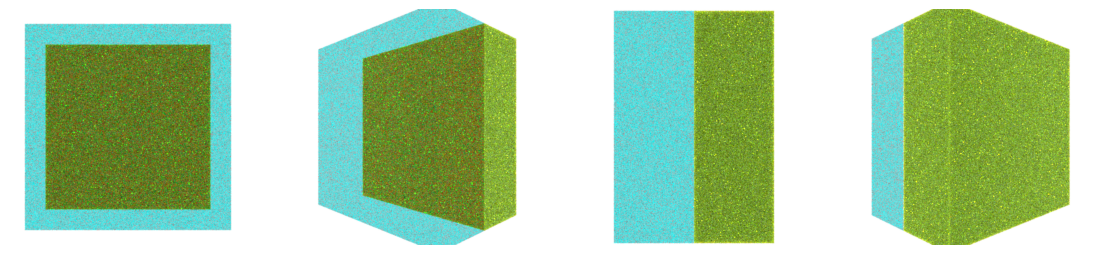

In [32]:
fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')

In [33]:
red_key_albedo = 'red_cude.interior_medium.albedo.value.value'
red_key_sigma_t = 'red_cude.interior_medium.sigma_t.value.value'

green_key_albedo = 'green_cude.interior_medium.albedo.value.value'
green_key_sigma_t = 'green_cude.interior_medium.sigma_t.value.value'

In [35]:
scale  = 0.1
scale_g = 0.1
alpha_r= np.array([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]) * scale
alpha_r = alpha_r[:, np.newaxis]
alpha_g = np.array([0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0])*scale_g
alpha_g = alpha_g[:, np.newaxis]



w_r = torch.tensor([0.0000, 0.5136, 0.4864, 0.0000, 0.0000, 0.0000])
w_g = torch.tensor([0.0944, 0.0000, 0.9056, 0.0000, 0.0000, 0.0000])

r_absorption = (w_r @ ink_absorption).detach().numpy()
r_scattering = (w_r @ ink_scattering).detach().numpy()
g_absorption = (w_g @ ink_absorption).detach().numpy()
g_scattering = (w_g @ ink_scattering).detach().numpy()

trans_absorption = ink_absorption[5].detach().numpy()
trans_scattering = ink_scattering[5].detach().numpy()


r_alpha_absorption = r_absorption * alpha_r + trans_absorption * (1 - alpha_r)
r_alpha_scattering = r_scattering * alpha_r + trans_scattering * (1 - alpha_r)
r_alpha_albedo = r_alpha_scattering / (r_alpha_absorption + r_alpha_scattering)
r_alpha_sgima_t = r_alpha_absorption + r_alpha_scattering

g_alpha_absorption = g_absorption * alpha_g + trans_absorption * (1 - alpha_g)
g_alpha_scattering = g_scattering * alpha_g + trans_scattering * (1 - alpha_g)
g_alpha_albedo = g_alpha_scattering / (g_alpha_absorption + g_alpha_scattering)
g_alpha_sgima_t = g_alpha_absorption + g_alpha_scattering



In [36]:
print(g_alpha_albedo[0], g_alpha_sgima_t[0])
print(g_alpha_albedo[6], g_alpha_sgima_t[6])

[1. 1. 1.] [4.99999987e-06 4.99999987e-06 4.99999987e-06]
[0.71841943 0.96221053 0.1828437 ] [0.0144405 0.0191085 0.0895765]


In [37]:
scene_2_layer = get_2_layer_scene(integrator_type = 'volpathmis')
params_2_layer = mi.traverse(scene_2_layer)

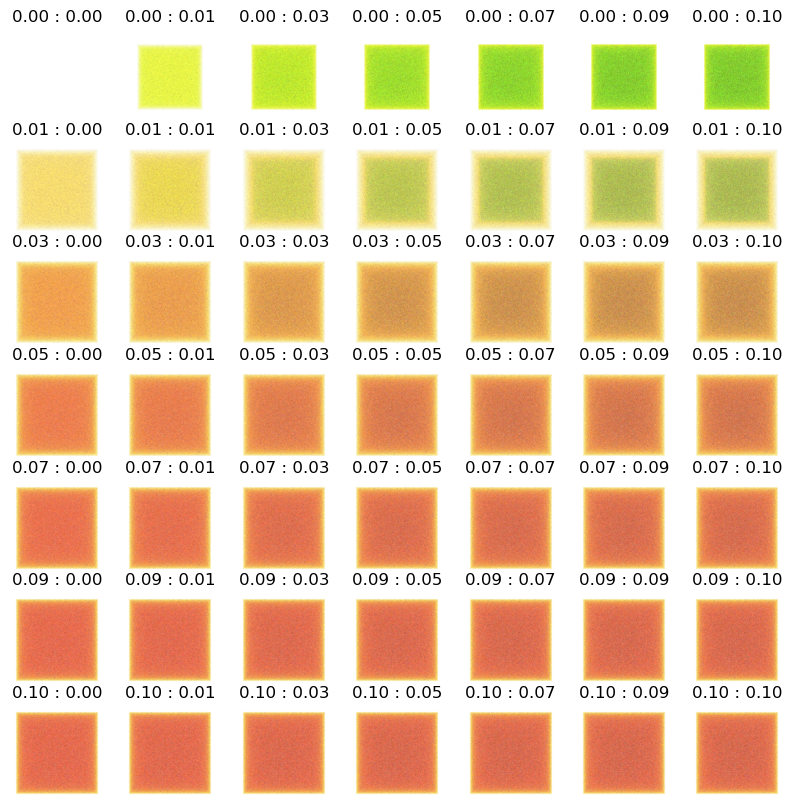

In [38]:
fig, axs = plt.subplots(len(alpha_r), len(alpha_g), figsize=(10, 10))

for i in range(len(alpha_r)):
    for j in range(len(alpha_g)):
        params_2_layer[red_key_albedo] = r_alpha_albedo[i]
        params_2_layer[red_key_sigma_t] = r_alpha_sgima_t[i]
        params_2_layer[green_key_albedo] = g_alpha_albedo[j]
        params_2_layer[green_key_sigma_t] = g_alpha_sgima_t[j]
        params_2_layer.update()

        img = mi.render(scene_2_layer, params_2_layer, sensor=sensors[0], spp=4)
        name = 'layer_add/r_{:.2f}_g_{:.2f}'.format(alpha_r[i][0], alpha_g[j][0])

        mi.Bitmap(img).write(name+'.exr')
        axs[i][j].imshow(mi.util.convert_to_bitmap(img))
        axs[i][j].title.set_text('{:.2f} : {:.2f}'.format(alpha_r[i][0], alpha_g[j][0]))
        axs[i][j].axis('off')
plt.savefig("layer_add/mix.png")
plt.show()

### check scene setting ###

In [15]:
scale  = 0.1
alpha_r = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0] 
alpha_r = [i * scale for i in alpha_r]
alpha_g = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
alpha_g = [i * scale for i in alpha_g]


w_r = torch.tensor([0.0000, 0.5136, 0.4864, 0.0000, 0.0000, 0.0000])
w_g = torch.tensor([0.0944, 0.0000, 0.9056, 0.0000, 0.0000, 0.0000])

r_absorption = w_r @ ink_absorption
r_scattering = w_r @ ink_scattering
g_absorption = w_g @ ink_absorption
g_scattering = w_g @ ink_scattering

trans_absorption = ink_absorption[5]
trans_scattering = ink_scattering[5]


g_r_aplha_blend_absorption = np.zeros(len(alpha_r)*len(alpha_g)*3).reshape(len(alpha_r),len(alpha_g),3)
g_r_aplha_blend_scattering = np.zeros(len(alpha_r)*len(alpha_g)*3).reshape(len(alpha_r),len(alpha_g),3)

for i, a_r in enumerate(alpha_r):
    for j, a_g in enumerate(alpha_g):
        is_red_front = a_r > a_g

        if is_red_front: # then we assume red is in the front
            red_coeff = a_r
            green_coeff = a_g * (1 - a_r)
        else:
            red_coeff = a_r * (1 - a_g)
            green_coeff = a_g

        g_r_aplha_blend_absorption[i][j] = r_absorption * red_coeff + g_absorption * green_coeff + trans_absorption * (1 - red_coeff - green_coeff)
        g_r_aplha_blend_scattering[i][j] = r_scattering * red_coeff + g_scattering * green_coeff + trans_scattering * (1- red_coeff - green_coeff)

final_albedo = g_r_aplha_blend_scattering / (g_r_aplha_blend_absorption + g_r_aplha_blend_scattering)
final_sigma_t = g_r_aplha_blend_absorption + g_r_aplha_blend_scattering


In [16]:

scene_alpha_blend = get_optimization_scene(integrator_type = 'volpathmis')
params_alpha_blend = mi.traverse(scene_alpha_blend)


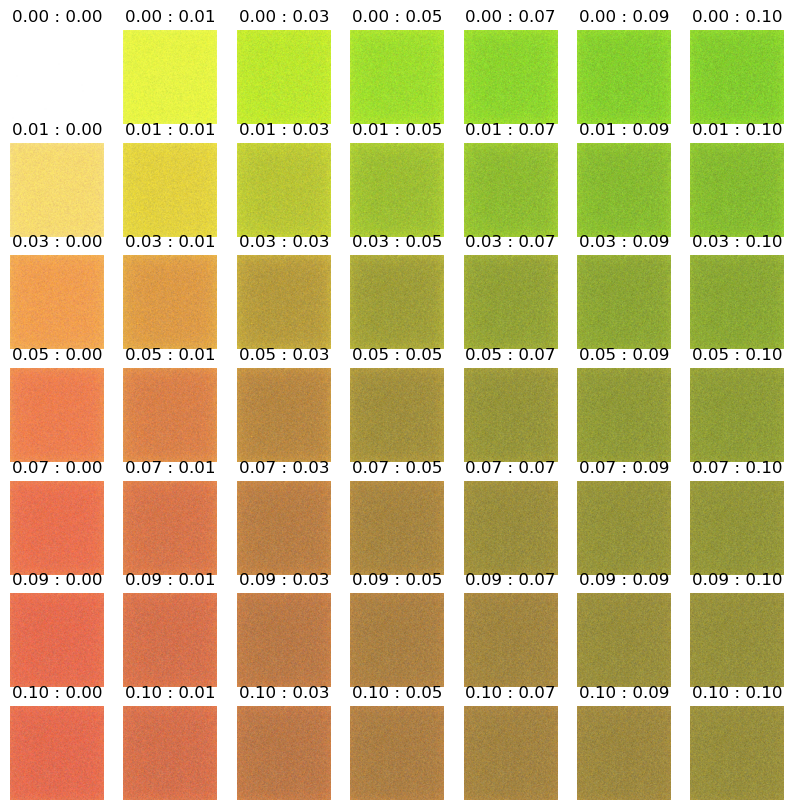

In [17]:
fig, axs = plt.subplots(len(alpha_r), len(alpha_g), figsize=(10, 10))
key_albedo = 'red_cude.interior_medium.albedo.value.value'
key_sigma_t = 'red_cude.interior_medium.sigma_t.value.value'
for i in range(len(alpha_r)):
    for j in range(len(alpha_g)):
        params_alpha_blend[key_albedo] = final_albedo[i][j]
        params_alpha_blend[key_sigma_t] = final_sigma_t[i][j]
        params_alpha_blend.update()
        img = mi.render(scene_alpha_blend, params_alpha_blend, sensor=sensors[0], spp=4)
        name = 'alpha_blend/r_{:.2f}_g_{:.2f}'.format(alpha_r[i], alpha_g[j])

        mi.Bitmap(img).write(name+'.exr')
        axs[i][j].imshow(mi.util.convert_to_bitmap(img))
        axs[i][j].title.set_text('{:.2f} : {:.2f}'.format(alpha_r[i], alpha_g[j]))
        axs[i][j].axis('off')
plt.savefig("alpha_blend/mix.png")
plt.show()
